# 利用Lidar数据创建不规则三角网（TIN）

> 备考：本实验没有使用 voronoi.py，而是使用 scipy 实现。
>
> 由于 laspy 的版本问题导致其用法改变，书上的代码没有办法直接复用。
> 
> 上述问题，以及部分函数的实现，均由 AI 帮助解决，最终搞出一整个 Jupyter Notebook。Perplexity 真好用吧。

## 1. 导入必要的库

In [1]:
# 导入基础库
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection
import sys
import os

import laspy
print(f"laspy version: {laspy.__version__}")

from scipy.spatial import Delaunay

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['HarmonyOS Sans SC']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

laspy version: 2.6.1


## 2. 定义辅助函数

In [2]:
def read_las_file(file_path):
    try:
        # 读取LAS文件
        las = laspy.read(file_path)
        
        # 提取坐标
        x = np.array(las.x)
        y = np.array(las.y)
        z = np.array(las.z)
        
        # 组合成点云数组
        points = np.column_stack((x, y, z))
        
        print(f"成功读取LAS文件: {file_path}")
        print(f"点云数量: {len(points)}")
        print(f"X范围: [{x.min():.2f}, {x.max():.2f}]")
        print(f"Y范围: [{y.min():.2f}, {y.max():.2f}]")
        print(f"Z范围: [{z.min():.2f}, {z.max():.2f}]")
        
        return points
    
    except Exception as e:
        print(f"读取LAS文件时出错: {e}")
        return None


def subsample_points(points, max_points=5000):
    if len(points) <= max_points:
        print(f"点云数量({len(points)})未超过限制，无需采样")
        return points
    
    # 随机采样
    indices = np.random.choice(len(points), max_points, replace=False)
    sampled_points = points[indices]
    
    print(f"点云采样: {len(points)} -> {len(sampled_points)}")
    return sampled_points


def create_tin_delaunay(points):
    # 使用XY坐标进行2D Delaunay三角剖分
    xy_points = points[:, :2]
    tri = Delaunay(xy_points)
    
    print(f"\nDelaunay三角剖分完成:")
    print(f"三角形数量: {len(tri.simplices)}")
    print(f"点数量: {len(tri.points)}")
    
    return tri


def calculate_triangle_stats(points, triangles):
    areas = []
    
    for tri in triangles:
        # 获取三角形的三个顶点
        p1, p2, p3 = points[tri]
        
        # 计算三角形面积（使用叉积）
        v1 = p2 - p1
        v2 = p3 - p1
        area = 0.5 * np.abs(np.cross(v1[:2], v2[:2]))
        areas.append(area)
    
    areas = np.array(areas)
    
    stats = {
        'mean_area': np.mean(areas),
        'median_area': np.median(areas),
        'min_area': np.min(areas),
        'max_area': np.max(areas),
        'std_area': np.std(areas)
    }
    
    return stats

## 3. 可视化函数

In [3]:
def plot_tin_full(points, tri, title="不规则三角网（TIN）- 整体视图", figsize=(15, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制三角形边
    ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'b-', linewidth=0.5, alpha=0.6)
    
    # 根据高程值着色点
    scatter = ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], 
                        cmap='terrain', s=1, alpha=0.8, edgecolors='none')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax, label='高程 (Z)', shrink=0.8)
    
    ax.set_xlabel('X坐标', fontsize=12)
    ax.set_ylabel('Y坐标', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_tin_zoom(points, tri, zoom_regions, titles=None, figsize=(16, 6)):
    if titles is None:
        titles = [f"局部放大视图 {i+1}" for i in range(len(zoom_regions))]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for idx, (ax, region, title) in enumerate(zip(axes, zoom_regions, titles)):
        x_min, x_max, y_min, y_max = region
        
        # 筛选在放大区域内的点和三角形
        mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
               (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
        
        # 绘制三角形
        ax.triplot(points[:, 0], points[:, 1], tri.simplices, 
                  'b-', linewidth=1.0, alpha=0.7)
        
        # 绘制点（根据高程着色）
        scatter = ax.scatter(points[mask, 0], points[mask, 1], 
                           c=points[mask, 2], cmap='terrain', 
                           s=20, alpha=0.9, edgecolors='black', linewidth=0.5)
        
        # 设置放大区域
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        # 添加颜色条
        cbar = plt.colorbar(scatter, ax=ax, label='高程 (Z)', shrink=0.9)
        
        ax.set_xlabel('X坐标', fontsize=11)
        ax.set_ylabel('Y坐标', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 添加区域边框
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                           linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    plt.tight_layout()
    return fig


def plot_3d_tin(points, tri, title="TIN 3D视图", figsize=(12, 10)):
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制三角形表面
    surf = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2],
                          triangles=tri.simplices, cmap='terrain',
                          alpha=0.8, edgecolor='black', linewidth=0.2)
    
    # 添加颜色条
    fig.colorbar(surf, ax=ax, label='高程 (Z)', shrink=0.6)
    
    ax.set_xlabel('X坐标', fontsize=11)
    ax.set_ylabel('Y坐标', fontsize=11)
    ax.set_zlabel('高程 (Z)', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # 设置视角
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    return fig

print("可视化函数定义完成！")

可视化函数定义完成！


## 4. 读取LiDAR数据

In [4]:
# 指定数据文件路径
las_file = "assets/Week11/clippedLAS.las"
points = read_las_file(las_file)

成功读取LAS文件: assets/Week11/clippedLAS.las
点云数量: 27197
X范围: [277900.13, 277975.12]
Y范围: [6122396.50, 6122471.49]
Z范围: [46.55, 63.49]


## 5. 数据预处理与采样

In [5]:
# 设置随机种子以保证可重复性
np.random.seed(42)

# 对点云进行采样（如果点数过多）
points_sampled = subsample_points(points, max_points=5000)

print(f"\n采样后点云统计:")
print(f"X范围: [{points_sampled[:, 0].min():.2f}, {points_sampled[:, 0].max():.2f}]")
print(f"Y范围: [{points_sampled[:, 1].min():.2f}, {points_sampled[:, 1].max():.2f}]")
print(f"Z范围: [{points_sampled[:, 2].min():.2f}, {points_sampled[:, 2].max():.2f}]")

点云采样: 27197 -> 5000

采样后点云统计:
X范围: [277900.18, 277975.12]
Y范围: [6122396.50, 6122471.47]
Z范围: [46.69, 63.43]


## 6. 构建不规则三角网（TIN）

In [6]:
# 使用Delaunay算法创建TIN
tri = create_tin_delaunay(points_sampled)

# 计算三角网统计信息
stats = calculate_triangle_stats(points_sampled, tri.simplices)

print(f"\n三角网统计信息:")
print(f"平均三角形面积: {stats['mean_area']:.4f}")
print(f"中位数三角形面积: {stats['median_area']:.4f}")
print(f"最小三角形面积: {stats['min_area']:.4f}")
print(f"最大三角形面积: {stats['max_area']:.4f}")
print(f"三角形面积标准差: {stats['std_area']:.4f}")


Delaunay三角剖分完成:
三角形数量: 8443
点数量: 5000

三角网统计信息:
平均三角形面积: 0.6612
中位数三角形面积: 0.5388
最小三角形面积: 0.0000
最大三角形面积: 4.7230
三角形面积标准差: 0.4738


/tmp/ipykernel_24643/3782053382.py:62: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * np.abs(np.cross(v1[:2], v2[:2]))


## 7. 可视化结果

绘制完整TIN结构

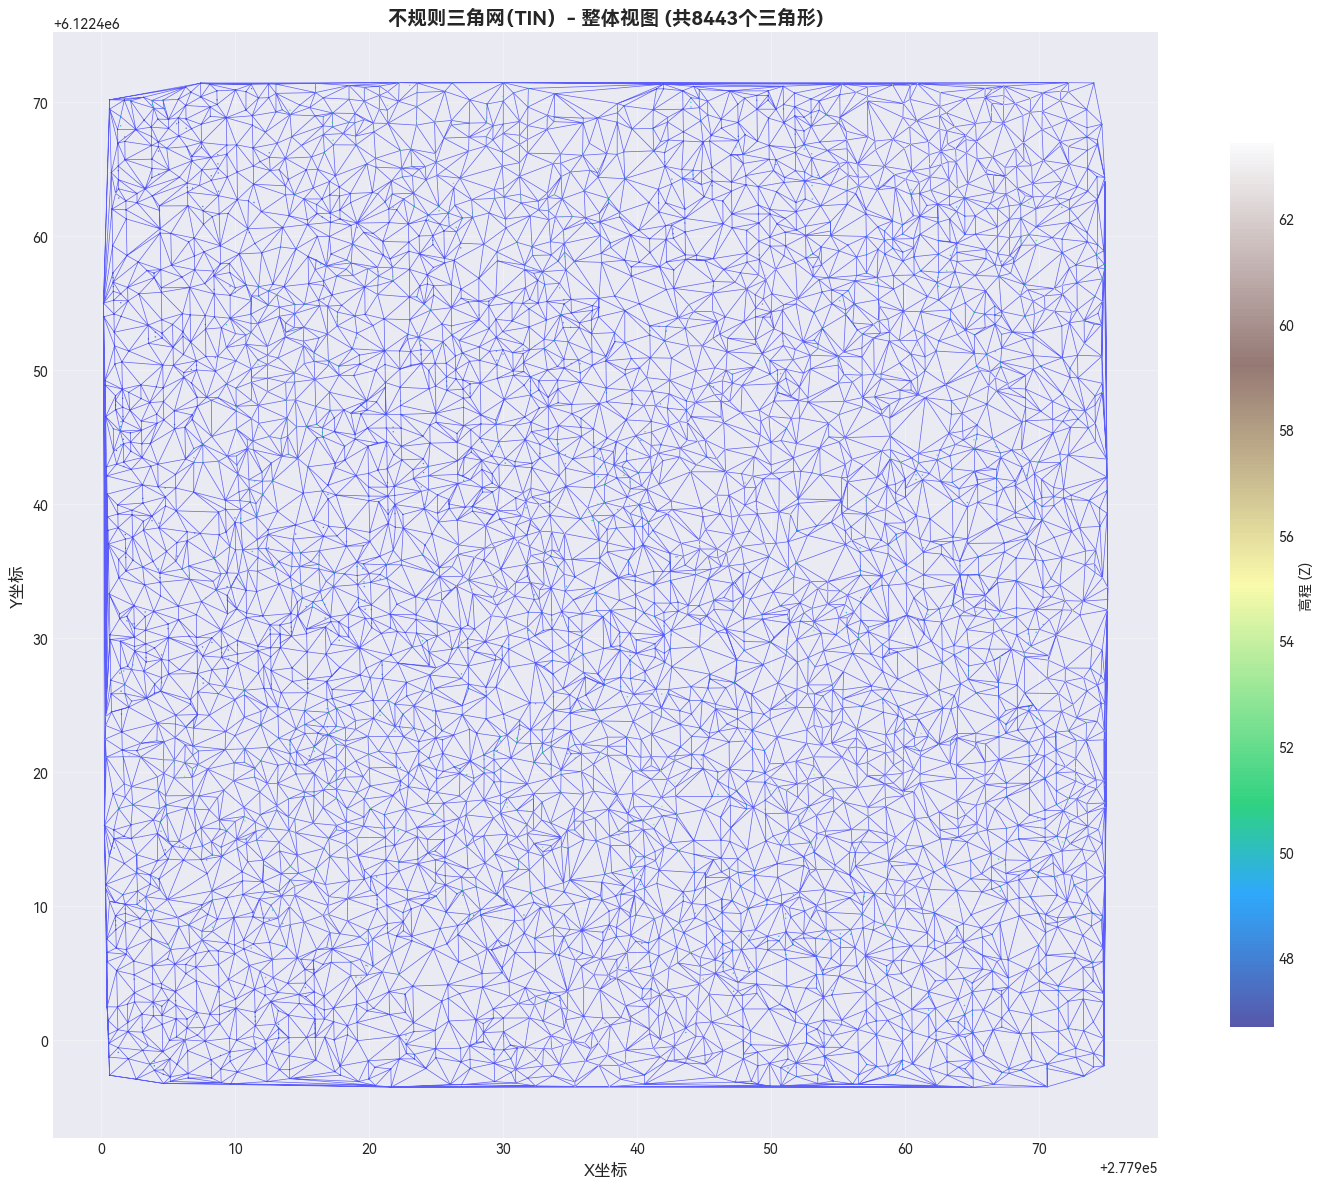

In [7]:
# 绘制整体TIN
fig1 = plot_tin_full(points_sampled, tri, 
                     title=f"不规则三角网（TIN）- 整体视图 (共{len(tri.simplices)}个三角形)")
plt.show()

选择两处局部区域进行放大

In [8]:
# 计算数据范围
x_min, x_max = points_sampled[:, 0].min(), points_sampled[:, 0].max()
y_min, y_max = points_sampled[:, 1].min(), points_sampled[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min

# 定义两个放大区域（选择左下和右上区域）
zoom_size_x = x_range * 0.15  # 放大区域为整体的15%
zoom_size_y = y_range * 0.15

# 区域1: 左下角附近
region1 = (
    x_min + x_range * 0.1,
    x_min + x_range * 0.1 + zoom_size_x,
    y_min + y_range * 0.1,
    y_min + y_range * 0.1 + zoom_size_y
)

# 区域2: 右上角附近
region2 = (
    x_max - x_range * 0.1 - zoom_size_x,
    x_max - x_range * 0.1,
    y_max - y_range * 0.1 - zoom_size_y,
    y_max - y_range * 0.1
)

zoom_regions = [region1, region2]
zoom_titles = [
    "局部放大视图 1 (左下区域)",
    "局部放大视图 2 (右上区域)"
]

print(f"放大区域1: X=[{region1[0]:.2f}, {region1[1]:.2f}], Y=[{region1[2]:.2f}, {region1[3]:.2f}]")
print(f"放大区域2: X=[{region2[0]:.2f}, {region2[1]:.2f}], Y=[{region2[2]:.2f}, {region2[3]:.2f}]")

放大区域1: X=[277907.67, 277918.91], Y=[6122404.00, 6122415.24]
放大区域2: X=[277956.39, 277967.63], Y=[6122452.73, 6122463.97]


绘制局部放大视图

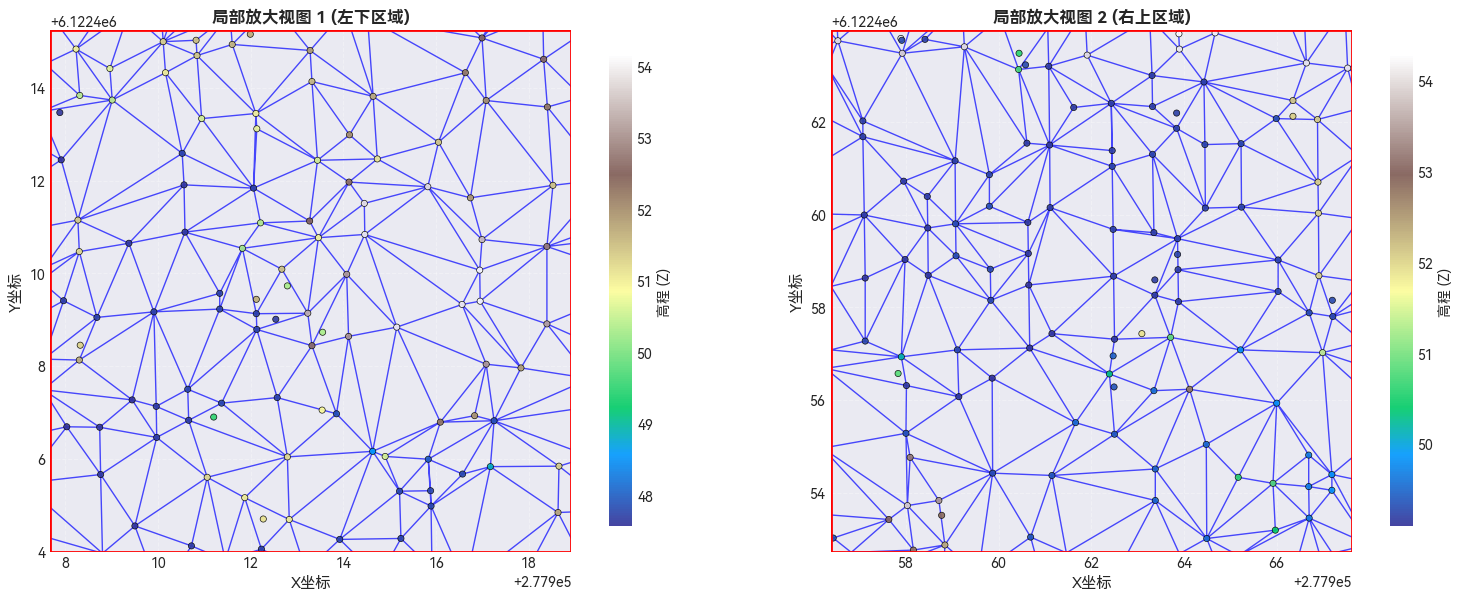

In [9]:
# 绘制两处局部放大
fig2 = plot_tin_zoom(points_sampled, tri, zoom_regions, titles=zoom_titles)
plt.show()